# Quadratic trends

More detailed information of this competition could be found in the notebook [Explain Dataset, Test API, Cross-Validation Tips](https://www.kaggle.com/code/vitalykudelya/explain-dataset-test-api-cross-validation-tips).

We have seen several successful notebooks which predict updrs scores based only on visit_month:
1. [Only Constants](https://www.kaggle.com/code/vitalykudelya/only-constants) doesn't even look at the month. Lb score = 56.9
2. [AMP® - PDPP - Baselines](https://www.kaggle.com/code/gunesevitan/amp-pdpp-baselines) computes medians and expanding window max values. LB score = 56.3
3. [Only Trends Version 2](https://www.kaggle.com/code/vitalykudelya/only-trends?scriptVersionId=126708822) optimizes linear trends for SMAPE. LB score = 56.2
4. [PDPP Almost Only Trends](https://www.kaggle.com/code/ambrosm/pdpp-almost-only-trends) recognizes that UPDRS_4 has a linear trend with a corner. LB score = 56.1

In a situation where linear regression gives good results it is always a good idea to try quadratic functions. This is what we do in the current notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from functools import partial

from scipy.optimize import minimize
from sklearn.model_selection import GroupKFold

# import amp_pd_peptide


In [2]:
train_clinical_data = pd.read_csv('data/train_clinical_data.csv')
train_clinical_data['source'] = 'standard'

supplemental_clinical_data = pd.read_csv('data/supplemental_clinical_data.csv')
supplemental_clinical_data['source'] = 'supplemental'

train_clinical_all = pd.concat([train_clinical_data, supplemental_clinical_data])

In [3]:
# delete visit_month 3, 5, 9 (there are no such visit_months in the Test API)
train_clinical_all = train_clinical_all[~train_clinical_all.visit_month.isin([3, 5, 9])]
train_clinical_all

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,source
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,standard
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,standard
4,55_12,55,12,10.0,10.0,41.0,0.0,On,standard
5,55_18,55,18,7.0,13.0,38.0,0.0,On,standard
6,55_24,55,24,16.0,9.0,49.0,0.0,On,standard
...,...,...,...,...,...,...,...,...,...
2217,65303_36,65303,36,4.0,1.0,26.0,0.0,NaN,supplemental
2218,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN,supplemental
2219,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN,supplemental
2221,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN,supplemental


In [4]:
train_clinical_all['pred_month'] = train_clinical_all['visit_month']

for plus_month in [6, 12, 24]:
    train_shift = train_clinical_all[['patient_id', 'visit_month', 'pred_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].copy()
    train_shift['visit_month'] -= plus_month
    train_shift.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_{plus_month}' for i in range(1, 5)}, inplace=True)
    train_shift.rename(columns={'pred_month': f'pred_month_plus_{plus_month}'}, inplace=True)
    train_clinical_all = train_clinical_all.merge(train_shift, how='left', on=['patient_id', 'visit_month'])

train_clinical_all.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_0' for i in range(1, 5)}, inplace=True)
train_clinical_all.rename(columns={'pred_month': f'pred_month_plus_0'}, inplace=True)
train_clinical_all

,visit_id,patient_id,visit_month,updrs_1_plus_0,updrs_2_plus_0,updrs_3_plus_0,updrs_4_plus_0,upd23b_clinical_state_on_medication,source,pred_month_plus_0,...,pred_month_plus_12,updrs_1_plus_12,updrs_2_plus_12,updrs_3_plus_12,updrs_4_plus_12,pred_month_plus_24,updrs_1_plus_24,updrs_2_plus_24,updrs_3_plus_24,updrs_4_plus_24
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,standard,0,...,12.0,10.0,10.0,41.0,0.0,24.0,16.0,9.0,49.0,0.0
1,55_6,55,6,8.0,10.0,34.0,NaN,NaN,standard,6,...,18.0,7.0,13.0,38.0,0.0,30.0,14.0,13.0,49.0,0.0
2,55_12,55,12,10.0,10.0,41.0,0.0,On,standard,12,...,24.0,16.0,9.0,49.0,0.0,36.0,17.0,18.0,51.0,0.0
3,55_18,55,18,7.0,13.0,38.0,0.0,On,standard,18,...,30.0,14.0,13.0,49.0,0.0,42.0,12.0,20.0,41.0,0.0
4,55_24,55,24,16.0,9.0,49.0,0.0,On,standard,24,...,36.0,17.0,18.0,51.0,0.0,48.0,17.0,16.0,52.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4501,65303_36,65303,36,4.0,1.0,26.0,0.0,NaN,supplemental,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4502,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN,supplemental,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4503,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN,supplemental,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4504,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN,supplemental,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# The model: finding the best trend

Our model deviates from the incumbent only in the predictions for UPDRS_3, which use a quadratic function:
- UPDRS_1 is a linear function.
- UPDRS_2 is a linear function.
- UPDRS_3 is a quadratic function.
- UPDRS_4 is constant for visit_month < 54 and linear for visit_month ≥ 54.


In [5]:
def smape_plus_1(y_true, y_pred):
    y_true_plus_1 = y_true + 1
    y_pred_plus_1 = y_pred + 1
    metric = np.zeros(len(y_true_plus_1))
    
    numerator = np.abs(y_true_plus_1 - y_pred_plus_1)
    denominator = ((np.abs(y_true_plus_1) + np.abs(y_pred_plus_1)) / 2)
    
    mask_not_zeros = (y_true_plus_1 != 0) | (y_pred_plus_1 != 0)
    metric[mask_not_zeros] = numerator[mask_not_zeros] / denominator[mask_not_zeros]
    
    return 100 * np.nanmean(metric)

def calculate_predictions(pred_month, trend, target):
    if target == 'updrs_4':
        pred_month = pred_month.clip(54, None)
    if len(trend) == 2:
        return np.round(trend[0] + pred_month * trend[1]) # linear prediction
    return np.round(trend[0] + pred_month * trend[1] + np.square(pred_month) * trend[2]) # quadratic prediction

def function_to_minimize(x, y_true_array_tr, pred_month_array_tr, target):
    metric = smape_plus_1(
        y_true=y_true_array_tr, 
        y_pred=calculate_predictions(
            pred_month=pred_month_array_tr,
            trend=x,
            target=target
        )
    )
    return metric

def model(y_true_array_tr, pred_month_array_tr, target):
    """Fits a linear or quadratic model to the given data"""
    return list(minimize(
        fun=partial(function_to_minimize,
                    y_true_array_tr=y_true_array_tr,
                    pred_month_array_tr=pred_month_array_tr,
                    target=target
                   ),
        # if x0 has two elements, the predictions will be linear
        # if x0 has three elements, the predictions will be quadratic
        x0=[0, 0.0048] if target != 'updrs_3' else [0, 0, 0],
        method='Powell'
    ).x)

# Cross-validation

We use a GroupKFold for cross-validation.

In [6]:
all_score_list = []
for i in range(1, 5):
    target = f'updrs_{i}'
    columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    kf = GroupKFold(n_splits=5)
    score_list = []
    for f, (idx_tr, idx_va) in enumerate(kf.split(train_clinical_all, groups=train_clinical_all.patient_id)):
        y_true_array_tr = train_clinical_all.iloc[idx_tr][columns_with_target].values.ravel()
        pred_month_array_tr = train_clinical_all.iloc[idx_tr][columns_with_pred_month].values.ravel()
        trend = model(y_true_array_tr, pred_month_array_tr, target)
        y_true_array_va = train_clinical_all.iloc[idx_va][columns_with_target].values.ravel()
        pred_month_array_va = train_clinical_all.iloc[idx_va][columns_with_pred_month].values.ravel()
        score = smape_plus_1(y_true_array_va, calculate_predictions(pred_month_array_va, trend, target))
        print(f"{target} fold {f}: {score:.2f}")
        score_list.append(score)
    score = np.array(score_list).mean()
    print(f"{target}                 {score:.2f}")
    all_score_list.append(score)
    
print(f"cv score                       {np.array(all_score_list).mean():.2f}")
# 55.07 without quadratic term
# 55.02 with quadratic term

updrs_1 fold 0: 54.65
updrs_1 fold 1: 57.32
updrs_1 fold 2: 54.01
updrs_1 fold 3: 55.41
updrs_1 fold 4: 54.91
updrs_1                 55.26
updrs_2 fold 0: 65.12
updrs_2 fold 1: 63.50
updrs_2 fold 2: 66.27
updrs_2 fold 3: 63.38
updrs_2 fold 4: 67.15
updrs_2                 65.08
updrs_3 fold 0: 57.58
updrs_3 fold 1: 60.46
updrs_3 fold 2: 56.01
updrs_3 fold 3: 57.27
updrs_3 fold 4: 59.24
updrs_3                 58.11
updrs_4 fold 0: 49.02
updrs_4 fold 1: 39.56
updrs_4 fold 2: 38.59
updrs_4 fold 3: 42.08
updrs_4 fold 4: 41.62
updrs_4                 42.17
cv score                       55.16


# Retraining

We retrain the model with the full data and plot the predictions. The diagrams show that the predictions for UPDRS_1 and UPDRS_2 are linear (rounded to the nearest integer), UPDRS_3 is quadratic, and UPDRS_4 has a corner at visit_month=60.

{'updrs_1': [5.394793062665313, 0.027091086167821344],
 'updrs_2': [5.469498130092747, 0.02824188329658148],
 'updrs_3': [21.450374496989554, 0.035651592857152345, 0.0010867699338717358],
 'updrs_4': [-4.434453480103724, 0.07531448585334258]}

[array([5., 6., 6., 6., 6., 6., 6., 7., 7., 7., 7., 7., 7., 8., 8., 8., 8.,
        8., 8.]),
 array([5., 6., 6., 6., 6., 6., 6., 7., 7., 7., 7., 7., 8., 8., 8., 8., 8.,
        8., 9.]),
 array([21., 22., 22., 22., 23., 23., 24., 25., 26., 27., 28., 29., 30.,
        31., 32., 33., 35., 36., 38.]),
 array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0.,  1.,  1.,
         1.,  2.,  2.,  3.,  3.,  4.])]

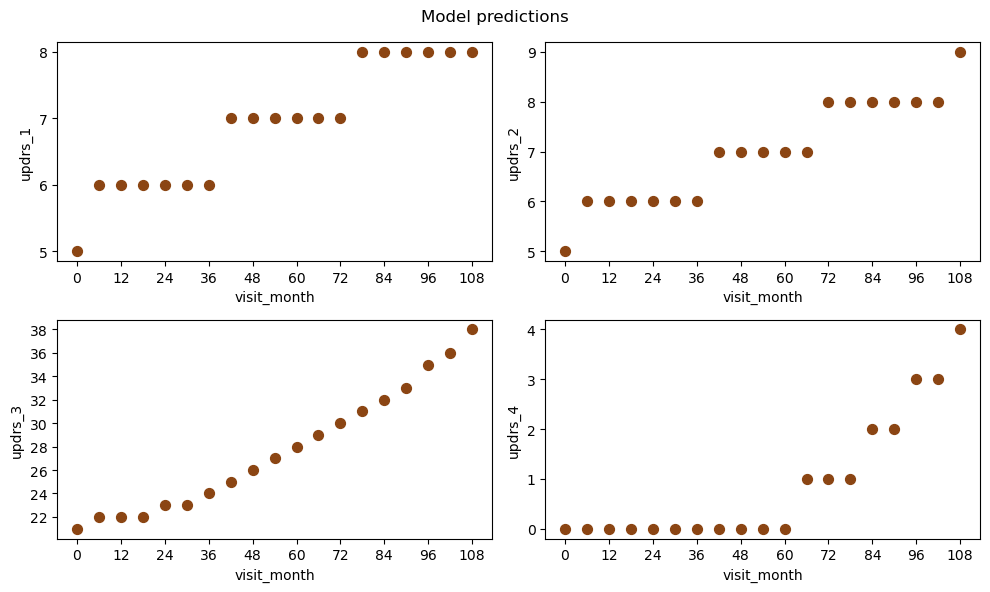

In [7]:
# Retrain with full data
target_to_trend = {}
for i in range(1, 5):
    target = f'updrs_{i}'
    columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    y_true_array = train_clinical_all[columns_with_target].values.ravel()
    pred_month_array = train_clinical_all[columns_with_pred_month].values.ravel()
    trend = model(y_true_array, pred_month_array, target)
    target_to_trend[target] = trend
display(target_to_trend)

# display prediction results
pred_res = []
for i in range(1, 5):
    target = f'updrs_{i}'
    pred_res.append(calculate_predictions(np.arange(0, 109, 6), target_to_trend[target], target))
display(pred_res)

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.suptitle('Model predictions')
for i in range(1, 5):
    target = f'updrs_{i}'
    plt.subplot(2, 2, i)
    plt.scatter(np.arange(0, 109, 6),
                calculate_predictions(np.arange(0, 109, 6), target_to_trend[target], target),
                color='saddlebrown', s=50)
    plt.xticks(np.linspace(0, 108, 10))
    plt.ylabel(f'updrs_{i}')
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('visit_month')
plt.tight_layout()
plt.show()

## Prediction
Only for kaggle online running.

In [8]:
test_data = pd.read_csv('./data/example_test_files/test.csv')
sample_result = pd.read_csv('./data/example_test_files/sample_submission.csv')
display(test_data)
display(sample_result)

,visit_id,visit_month,patient_id,updrs_test,row_id,group_key
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,0
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,0
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,0
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,0
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,0
5,50423_0,0,50423,updrs_2,50423_0_updrs_2,0
6,50423_0,0,50423,updrs_3,50423_0_updrs_3,0
7,50423_0,0,50423,updrs_4,50423_0_updrs_4,0
8,3342_6,6,3342,updrs_1,3342_6_updrs_1,6
9,3342_6,6,3342,updrs_2,3342_6_updrs_2,6


,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,0,0
1,3342_0_updrs_1_plus_6_months,0,0
2,3342_0_updrs_1_plus_12_months,0,0
3,3342_0_updrs_1_plus_24_months,0,0
4,3342_0_updrs_2_plus_0_months,0,0
...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6
60,50423_6_updrs_4_plus_0_months,0,6
61,50423_6_updrs_4_plus_6_months,0,6
62,50423_6_updrs_4_plus_12_months,0,6


In [10]:
sample_result['patient_id'] = sample_result['prediction_id'].map(lambda x: int(x.split('_')[0]))
sample_result['visit_month'] = sample_result['prediction_id'].map(lambda x: int(x.split('_')[1]))
sample_result['target_name'] = sample_result['prediction_id'].map(lambda x: 'updrs_' + x.split('_')[3])
sample_result['plus_month'] = sample_result['prediction_id'].map(lambda x: int(x.split('_')[5]))
sample_result['pred_month'] = sample_result['visit_month'] + sample_result['plus_month']
display(sample_result)

for i in range(1, 5):
    target = f'updrs_{i}'
    mask_target = sample_result['target_name'] == target
    print(target, mask_target.shape)
    sample_result.loc[mask_target, 'rating'] = calculate_predictitons(
        pred_month=sample_result.loc[mask_target, 'pred_month'],
        trend=target_to_trend[target]
    )

,prediction_id,rating,group_key,patient_id,visit_month,target_name,plus_month,pred_month
0,3342_0_updrs_1_plus_0_months,0,0,3342,0,updrs_1,0,0
1,3342_0_updrs_1_plus_6_months,0,0,3342,0,updrs_1,6,6
2,3342_0_updrs_1_plus_12_months,0,0,3342,0,updrs_1,12,12
3,3342_0_updrs_1_plus_24_months,0,0,3342,0,updrs_1,24,24
4,3342_0_updrs_2_plus_0_months,0,0,3342,0,updrs_2,0,0
...,...,...,...,...,...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6,50423,6,updrs_3,24,30
60,50423_6_updrs_4_plus_0_months,0,6,50423,6,updrs_4,0,6
61,50423_6_updrs_4_plus_6_months,0,6,50423,6,updrs_4,6,12
62,50423_6_updrs_4_plus_12_months,0,6,50423,6,updrs_4,12,18


updrs_1 (64,)


NameError: name 'calculate_predicitons' is not defined

In [ ]:
amp_pd_peptide.make_env.func_dict['__called__'] = False
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

# The API will deliver four dataframes in this specific order:
for test_clinical_data, test_peptides, test_proteins, sample_submission in iter_test:
    sample_submission['patient_id'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[0]))
    sample_submission['visit_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[1]))
    sample_submission['target_name'] = sample_submission['prediction_id'].map(lambda x: 'updrs_' + x.split('_')[3])
    sample_submission['plus_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[5]))
    sample_submission['pred_month'] = sample_submission['visit_month'] + sample_submission['plus_month']

    for i in range(1, 5):
        target = f'updrs_{i}'
        mask_target = sample_submission['target_name'] == target
        print(target, mask_target)
        sample_submission.loc[mask_target, 'rating'] = calculate_predicitons(
            pred_month=sample_submission.loc[mask_target, 'pred_month'],
            trend=target_to_trend[target]
        )

    # call the env.predict for every iteration
    env.predict(sample_submission[['prediction_id', 'rating']])